In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
def custom_image_preprocess(image):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(factor=(-0.2, 0.3)),
        tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])
    return data_augmentation(image)

In [ ]:
BATCH_SIZE = 16
IMG_HEIGHT = 72
IMG_WIDTH = 72

train_dir = "/content/unzipped_folder/Alzheimer_s Dataset/train"
test_dir = "/content/unzipped_folder/Alzheimer_s Dataset/test"

tf.random.set_seed(1234)

In [ ]:
train_image_generator = ImageDataGenerator(
    rescale=1. / 255,
    vertical_flip=True,
    horizontal_flip=True,
)
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    color_mode='rgb'
)

test_image_generator = ImageDataGenerator(
    rescale=1. / 255,
    vertical_flip=True,
    horizontal_flip=True,
)
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    shuffle=False,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical',
    color_mode='rgb'
)

# Get class names
class_names = list(test_data_gen.class_indices.keys())
num_classes = len(class_names)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
def baseline_model(num_classes):
    model = Sequential([
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_2'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_3'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = baseline_model(num_classes)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
epochs = 100
history = model.fit(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=epochs,
    callbacks=[callback]
)


Epoch 1/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - categorical_accuracy: 0.6250 - loss: 0.7905 - val_categorical_accuracy: 0.5747 - val_loss: 0.9417 - learning_rate: 0.0010
Epoch 2/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - categorical_accuracy: 0.6275 - loss: 0.7708 - val_categorical_accuracy: 0.5481 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 3/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - categorical_accuracy: 0.6386 - loss: 0.7448 - val_categorical_accuracy: 0.5395 - val_loss: 1.0662 - learning_rate: 0.0010
Epoch 4/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.6537 - loss: 0.7209 - val_categorical_accuracy: 0.5496 - val_loss: 1.0386 - learning_rate: 0.0010
Epoch 5/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - categorical_accuracy: 0.6549 - loss: 0.7147 - val_categorical_accuracy: 0.5512 - val_loss: 1.0588 - learning_rate: 0.0010
Epoch 6/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - categorical_accuracy: 0.6648 - loss: 0.7030 - val_cate

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Categorical Accuracy: 0.5919
Categorical Accuracy (TensorFlow): 0.5919
Precision (macro): 0.6994
Recall (macro): 0.3868
F1 Score (macro): 0.4092

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.65      0.17      0.27       179
ModerateDemented       1.00      0.08      0.15        12
     NonDemented       0.66      0.76      0.70       640
VeryMildDemented       0.49      0.54      0.51       448

        accuracy                           0.59      1279
       macro avg       0.70      0.39      0.41      1279
    weighted avg       0.60      0.59      0.57      1279



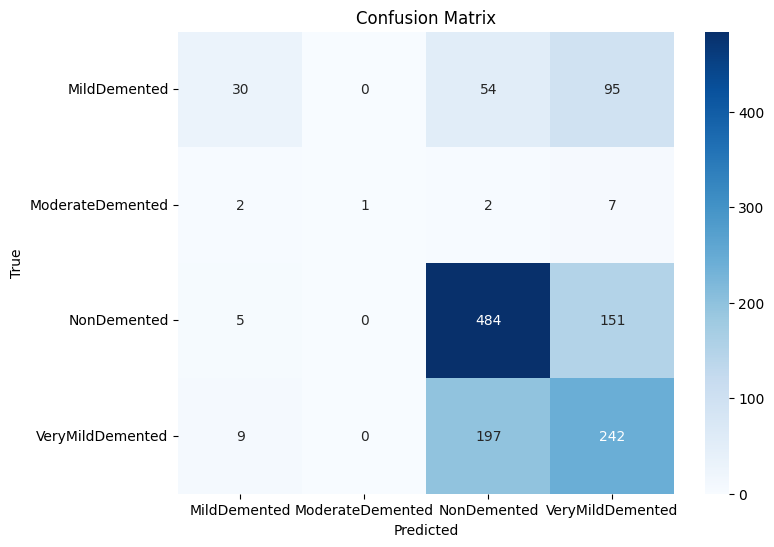

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import CategoricalAccuracy

# Predict probabilities
y_pred_probs = model.predict(test_data_gen)
# Convert to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_data_gen.classes

# Categorical accuracy using sklearn (same as categorical accuracy from Keras)
categorical_acc = accuracy_score(y_true, y_pred)
print(f"Categorical Accuracy: {categorical_acc:.4f}")

# Optionally, using TensorFlow's CategoricalAccuracy (requires one-hot labels)
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(test_data_gen.class_indices))
categorical_acc_metric = CategoricalAccuracy()
categorical_acc_metric.update_state(y_true_one_hot, y_pred_probs)
print(f"Categorical Accuracy (TensorFlow): {categorical_acc_metric.result().numpy():.4f}")

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_data_gen.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data_gen.class_indices.keys(),
            yticklabels=test_data_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
